In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.nn.functional as F
import torch.optim as optim
import random
from models import GCN

import matplotlib.pyplot as plt

from sklearn import metrics
from utils import get_plot

In [2]:
from data_process import generate_data, load_data
from train_func import test, train, Block_matrix_train, Lhop_Block_matrix_train, Communicate_train, ADMM_communication_train, Block_matrix_train_batch

In [3]:
def get_K_hop_neighbors(adj_matrix, index, K):
    adj_matrix = adj_matrix + torch.eye(adj_matrix.shape[0],adj_matrix.shape[1])  #make sure the diagonal part >= 1
    hop_neightbor_index=index
    for i in range(K):
        hop_neightbor_index=torch.unique(torch.nonzero(adj[hop_neightbor_index])[:,1]) #include 1-k hop neightbors
    return hop_neightbor_index

In [4]:
def get_gradient_two_layer(features, adj_2_hop, adj_1_hop, number_of_datapoints):
    #adj_2_hop = normalize(adj_2_hop)
    #adj_1_hop = normalize(adj_1_hop)
    return torch.norm(features.T.mm(adj_2_hop.T).mm(adj_1_hop.T).mm(adj_1_hop).mm(adj_2_hop).mm(features)) / number_of_datapoints

In [5]:
import scipy.sparse as sp
def normalize(mx):
    """Row-normalize sparse matrix"""
    
    mx = mx + torch.eye(mx.shape[0],mx.shape[1])
    
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return torch.tensor(mx)

In [6]:

def get_graph(dataset_name, iid_percent, K_over_class_num):
    
        if dataset_name=='simulate':
            

            number_of_nodes=200
            class_num=3
            link_inclass_prob=10/number_of_nodes  #when calculation , remove the link in itself
            #EGCN good when network is dense 20/number_of_nodes  #fails when network is sparse. 20/number_of_nodes/5
            link_outclass_prob=link_inclass_prob/20
            features, adj, labels, idx_train, idx_val, idx_test =generate_data(number_of_nodes,  class_num, link_inclass_prob, link_outclass_prob)               
        else:
            #'cora', 'citeseer', 'pubmed' #other dataset twitter, 
            

            features, adj, labels, idx_train, idx_val, idx_test = load_data(dataset_name)
            class_num = labels.max().item() + 1


        #client num
        K = K_over_class_num * class_num
        
        
        split_data_indexes=[]
        
        nclass=labels.max().item() + 1
        split_data_indexes = []
        non_iid_percent = 1 - float(iid_percent)
        iid_indexes = [] #random assign
        shuffle_labels = [] #make train data points split into different devices
        for i in range(K):
            current = torch.nonzero(labels == i).reshape(-1)
            current = current[np.random.permutation(len(current))] #shuffle
            shuffle_labels.append(current)
                
        average_device_of_class = K // nclass
        if K % nclass != 0: #for non-iid
            average_device_of_class += 1
        for i in range(K):  
            label_i= i // average_device_of_class    
            labels_class = shuffle_labels[label_i]

            average_num= int(len(labels_class)//average_device_of_class * non_iid_percent)
            split_data_indexes.append(np.array(labels_class[average_num * (i % average_device_of_class):average_num * (i % average_device_of_class + 1)]))
        
        L = []
        for i in split_data_indexes:
            L += list(i)
        L.sort()
        iid_indexes = np.setdiff1d(range(len(labels)), L)
        
        for i in range(K):  #for iid
            label_i= i // average_device_of_class
            labels_class = shuffle_labels[label_i]

            average_num= int(len(labels_class)//average_device_of_class * (1 - non_iid_percent))
            split_data_indexes[i] = list(split_data_indexes[i]) + list(iid_indexes[:average_num])
                    
            iid_indexes = iid_indexes[average_num:]
        
        
        #get train indexes in each device, only part of nodes in each device have labels in the train process
        split_train_ids = []
        for i in range(K):
            split_data_indexes[i].sort()
            inter = np.intersect1d(split_data_indexes[i], idx_train)
            split_train_ids.append(np.searchsorted(split_data_indexes[i], inter))   #local id in block matrix

        one_hot_labels = F.one_hot(labels).float()
        
        return features, adj, labels, one_hot_labels, split_data_indexes, K


In [76]:
import numpy as np
np.random.seed(42)
torch.manual_seed(42)
dataset_name='cora'
args_normalize = True

List_one_hop_count = []
List_two_hop_count = []
List_BDS_one_local_update = []


for percent in range(0, 11, 1):
    length_current_index = []
    length_neighbor1 = []
    length_neighbor2 = []
    
    for time in range(1):
        iid_percent = percent / 10
        K_over_class_num = 1
        features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph(dataset_name, iid_percent, K_over_class_num)
        if dataset_name=='simulate':
                feature = one_hot_labels
        if args_normalize:
            adj = normalize(adj)
        one_hop_count = 0
        two_hop_count = 0
        BDS_one_local_update = 0
        for i in range(len(split_data_indexes)):
                current_index = split_data_indexes[i]

                neighbor1 = get_K_hop_neighbors(adj, current_index, 1)

                neighbor2 = get_K_hop_neighbors(adj, current_index, 2)
                #print(current_index)
                #1-hop communication
                for node in current_index:
                    communicate_client = set()
                    #print(node, adj[node].nonzero())
                    for neighbor in adj[node].nonzero():
                        #print(neighbor)
                        if neighbor in current_index: #skip inside nodes
                            continue
                        for j in range(len(split_data_indexes)):
                            if neighbor in split_data_indexes[j]:
                                communicate_client.add(j)
                                break
                    #print(i, len(communicate_client))
                    #print(len(communicate_client))
                    one_hop_count += len(communicate_client)
                    two_hop_count += len(communicate_client)
                
                #2hop, since we have done 1-hop communication, we only needs to know the accumulation of features of neighbors
                two_hop_count += (len(neighbor1) - len(current_index))
                
                
                BDS_one_local_update += (len(neighbor1) - len(current_index))
        print(percent, one_hop_count, two_hop_count, BDS_one_local_update)
        List_one_hop_count.append(one_hop_count)
        List_two_hop_count.append(two_hop_count)
        List_BDS_one_local_update.append(BDS_one_local_update)
                    


/Users/yhyao/Desktop/Federated-GCN-main/data_process.py:130: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))


0 1275 2550 1275
1 2060 4128 2068
2 2754 5516 2762
3 3393 6796 3403
4 3891 7791 3900
5 4300 8604 4304
6 4714 9436 4722
7 4957 9925 4968
8 5119 10249 5130
9 5199 10409 5210
10 5114 10228 5114


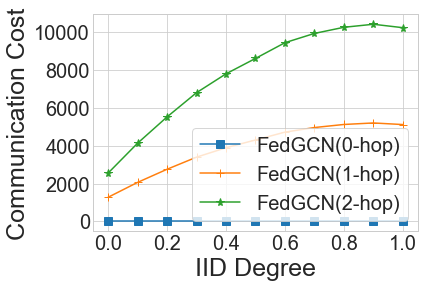

In [58]:

plt.style.use('seaborn-whitegrid')
X = np.array(range(0, 11, 1)) / 10
plt.plot(X, [0]*len(X), 's-', label = 'FedGCN(0-hop)', markersize=8)
plt.plot(X, List_one_hop_count, '+-', label = 'FedGCN(1-hop)', markersize=8)
plt.plot(X, List_two_hop_count, '*-', label = 'FedGCN(2-hop)', markersize=8)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('IID Degree', fontsize=25)
plt.ylabel('Communication Cost', fontsize=25)
plt.legend(fontsize=20, frameon=True, loc = 'best')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.savefig("cora_communication_cost_changeIID.png", format='png')
plt.savefig("cora_communication_cost_changeIID.pdf", format='pdf')

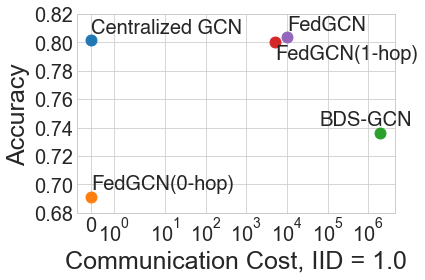

In [298]:
bds_one = 5114
L = 2
T_iid =128
tau = 3
rho = 0.5
iid_total_bds = bds_one * L * T_iid * tau * rho

plt.style.use('seaborn-whitegrid')
x = [0, 5114, 10228, iid_total_bds, 0]
y = [0.6915 , 0.8001 , 0.8038, 0.7365, 0.8013 ]
n = ["FedGCN(0-hop)", "FedGCN(1-hop)", "FedGCN", "BDS-GCN", "Centralized GCN"]

fig, ax = plt.subplots()
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[0], y[0], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)



hfont = {'fontname':'Helvetica'}

for i, txt in enumerate(n):
        
    if '0-hop' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.005), fontsize=20, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i], y[i] - 0.012), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.005), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i] - 1900000, y[i] + 0.005), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.005), fontsize=20, **hfont)
        
        
#ax.set_xscale('log')
plt.ylim(0.68,0.82)
ax.set_xscale('symlog')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, IID = 1.0', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')
plt.savefig("cora_comm_accuracy_IID.eps", format='eps')

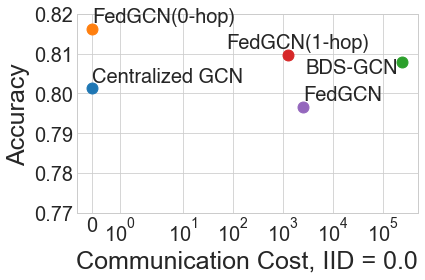

In [302]:
plt.style.use('seaborn-whitegrid')
T_non_iid = 64
bds_one = 1275


non_iid_total_bds =  bds_one* L * T_non_iid * tau * rho
x=[0, 1275, 2550, non_iid_total_bds, 0]
y=[0.8163 , 0.8097, 0.7966 , 0.8079, 0.8013 ]
n=["FedGCN(0-hop)", "FedGCN(1-hop)", "FedGCN", "BDS-GCN", "Centralized GCN"]

fig, ax = plt.subplots()
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[0], y[0], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)

hfont = {'fontname':'Helvetica'}



for i, txt in enumerate(n):
    if '0-hop' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.0016), fontsize=20, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i] - 1200, y[i] + 0.0016), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.0016), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i] - 242000, y[i] - 0.0028), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i], y[i] + 0.0016), fontsize=20, **hfont)
        
#ax.set_xscale('log')
plt.ylim([0.77,0.82])
ax.set_xscale('symlog')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, IID = 0.0', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')
plt.savefig("cora_comm_accuracy_Non-IID.eps", format='eps')

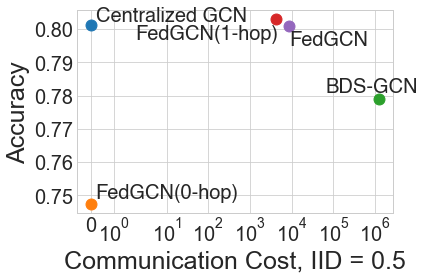

In [313]:
plt.style.use('seaborn-whitegrid')
T_partial_iid = 94
partial_iid_total_bds = 4304 * L * T_partial_iid * tau * rho
x=[0, 4300, 8604 , partial_iid_total_bds, 0]
y=[0.7475, 0.8030, 0.8010, 0.7791, 0.8013]
n=["FedGCN(0-hop)", "FedGCN(1-hop)", "FedGCN", "BDS-GCN", "Centralized GCN"]

fig, ax = plt.subplots()
ax.scatter(x[4], y[4], s=120)
ax.scatter(x[0], y[0], s=120)
ax.scatter(x[3], y[3], s=120)
ax.scatter(x[1], y[1], s=120)
ax.scatter(x[2], y[2], s=120)

hfont = {'fontname':'Helvetica'}



for i, txt in enumerate(n):
    if '0-hop' in txt:
        ax.annotate(txt, (x[i]+0.2, y[i] + 0.0015), fontsize=20, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i] - 4298.1, y[i] - 0.006), fontsize=20, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i] - 0.006), fontsize=20, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i] - 1150000, y[i] + 0.002), fontsize=20, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i] + 0.2, y[i] + 0.001), fontsize=20, **hfont)
#ax.set_xscale('log')
#plt.ylim(0.79,0.82)
ax.set_xscale('symlog')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost, IID = 0.5', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')
plt.savefig("cora_comm_accuracy_partial.eps", format='eps')




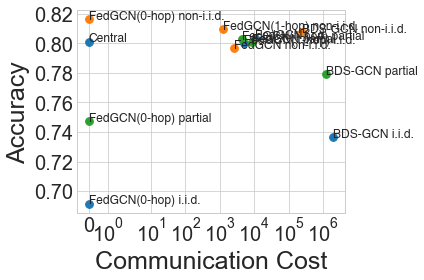

In [231]:
bds_one = 5114
L = 2
T_iid =128
tau = 3
rho = 0.5
iid_total_bds = bds_one * L * T_iid * tau * rho

plt.style.use('seaborn-whitegrid')
x = [0, 5114, 10228, iid_total_bds, 0]
y = [0.6915 , 0.8001 , 0.8038, 0.7365, 0.8013 ]
n = ["FedGCN(0-hop) i.i.d.", "FedGCN(1-hop) i.i.d.", "FedGCN i.i.d.", "BDS-GCN i.i.d.", "Central"]

fig, ax = plt.subplots()
ax.scatter(x, y, s=60)

hfont = {'fontname':'Helvetica'}

for i, txt in enumerate(n):
    if '0-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'Central' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)

        
T_non_iid = 64
bds_one = 1275


non_iid_total_bds =  bds_one* L * T_non_iid * tau * rho
x=[0, 1275, 2550, non_iid_total_bds]
y=[0.8163 , 0.8097, 0.7966 , 0.8079]
n=["FedGCN(0-hop) non-i.i.d.", "FedGCN(1-hop) non-i.i.d.", "FedGCN non-i.i.d.", "BDS-GCN non-i.i.d."]
ax.scatter(x, y, s=60)

for i, txt in enumerate(n):
    if '0-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
      

T_partial_iid = 94
partial_iid_total_bds = 4304 * L * T_partial_iid * tau * rho
x=[0, 4300, 8604 , partial_iid_total_bds]
y=[0.7475, 0.8030, 0.8010, 0.7791]
n=["FedGCN(0-hop) partial", "FedGCN(1-hop) partial", "FedGCN partial", "BDS-GCN partial"]
ax.scatter(x, y, s=60)

for i, txt in enumerate(n):
    if '0-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif '1-hop' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'FedGCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
    elif 'BDS-GCN' in txt:
        ax.annotate(txt, (x[i], y[i]), fontsize=12, **hfont)
     
        
#ax.set_xscale('log')
#plt.ylim(0.68,0.82)
ax.set_xscale('symlog')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Communication Cost', fontsize=25)
plt.ylabel('Accuracy', fontsize=25)
#plt.legend(fontsize=20, frameon=True, loc = 'best')
plt.savefig("cora_comm_accuracy_IID.png", format='png')

In [9]:
import numpy as np
np.random.seed(42)
torch.manual_seed(42)
dataset_name='simulate'
args_normalize = True

List_one_hop_count = []
List_two_hop_count = []
List_BDS_one_local_update = []


for percent in range(0, 11, 1):
    length_current_index = []
    length_neighbor1 = []
    length_neighbor2 = []
    
    for time in range(10):
        iid_percent = percent / 10
        K_over_class_num = 1
        features, adj, labels, one_hot_labels, split_data_indexes, K = get_graph(dataset_name, iid_percent, K_over_class_num)
        if dataset_name=='simulate':
                feature = one_hot_labels
        if args_normalize:
            adj = normalize(adj)
        one_hop_count = 0
        two_hop_count = 0
        BDS_one_local_update = 0
        for i in range(len(split_data_indexes)):
                current_index = split_data_indexes[i]

                neighbor1 = get_K_hop_neighbors(adj, current_index, 1)

                neighbor2 = get_K_hop_neighbors(adj, current_index, 2)
                #print(current_index)
                #1-hop communication
                for node in current_index:
                    communicate_client = set()
                    #print(node, adj[node].nonzero())
                    for neighbor in adj[node].nonzero():
                        #print(neighbor)
                        if neighbor in current_index: #skip inside nodes
                            continue
                        for j in range(len(split_data_indexes)):
                            if neighbor in split_data_indexes[j]:
                                communicate_client.add(j)
                                break
                    #print(i, len(communicate_client))
                    #print(len(communicate_client))
                    one_hop_count += len(communicate_client)
                    two_hop_count += len(communicate_client)
                
                #2hop, since we have done 1-hop communication, we only needs to know the accumulation of features of neighbors
                two_hop_count += (len(neighbor1) - len(current_index))
                
                
                BDS_one_local_update += (len(neighbor1) - len(current_index))
        print(percent, one_hop_count, two_hop_count, BDS_one_local_update)
        List_one_hop_count.append(one_hop_count)
        List_two_hop_count.append(two_hop_count)
        List_BDS_one_local_update.append(BDS_one_local_update)
                    
List_one_hop_count = [np.average(i) for i in np.array(List_one_hop_count).reshape(11,10)]
List_two_hop_count = [np.average(i) for i in np.array(List_two_hop_count).reshape(11,10)]
List_BDS_one_local_update = [np.average(i) for i in np.array(List_BDS_one_local_update).reshape(11,10)]

0 51 102 51
0 59 118 59
0 61 122 61
0 55 110 55
0 39 78 39
0 66 132 66
0 50 100 50
0 44 88 44
0 48 96 48
0 57 114 57
1 120 243 123
1 99 201 102
1 89 183 94
1 87 179 92
1 93 189 96
1 91 185 94
1 98 199 101
1 84 174 90
1 100 203 103
1 111 226 115
2 162 330 168
2 131 267 136
2 125 255 130
2 122 247 125
2 130 266 136
2 162 329 167
2 140 286 146
2 131 268 137
2 142 287 145
2 132 270 138
3 156 318 162
3 176 355 179
3 161 326 165
3 195 393 198
3 175 354 179
3 163 330 167
3 185 375 190
3 176 357 181
3 167 337 170
3 146 297 151
4 212 429 217
4 193 389 196
4 198 399 201
4 209 425 216
4 207 421 214
4 200 404 204
4 210 425 215
4 208 418 210
4 191 389 198
4 205 416 211
5 236 476 240
5 197 397 200
5 233 469 236
5 210 420 210
5 247 494 247
5 236 476 240
5 214 431 217
5 186 376 190
5 227 460 233
5 209 421 212
6 236 477 241
6 251 508 257
6 251 505 254
6 232 470 238
6 252 509 257
6 229 465 236
6 242 488 246
6 244 490 246
6 263 532 269
6 245 497 252
7 256 516 260
7 271 550 279
7 240 487 247
7 264 537 273

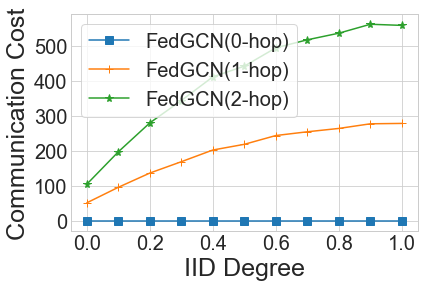

In [25]:

plt.style.use('seaborn-whitegrid')
X = np.array(range(0, 11, 1)) / 10
plt.plot(X, [0]*len(X), 's-', label = 'FedGCN(0-hop)', markersize=8)
plt.plot(X, List_one_hop_count, '+-', label = 'FedGCN(1-hop)', markersize=8)
plt.plot(X, List_two_hop_count, '*-', label = 'FedGCN(2-hop)', markersize=8)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('IID Degree', fontsize=25)
plt.ylabel('Communication Cost', fontsize=25)
plt.legend(fontsize=20, frameon=True, loc = 'best')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.savefig("simulate_communication_cost_changeIID.png", format='png')
plt.savefig("simulate_communication_cost_changeIID.pdf", format='pdf')